# Optimizing Factor Portfolios with Hierarchical Clustering

This notebook present how weight is allocate thourgh all global factors.

## Load libraries

In [1]:
import os
import sys

os.chdir("../..")

cwd = os.getcwd()

for root, dirs, file in os.walk(cwd):
    sys.path.append(root)

In [2]:
cwd

'c:\\Users\\HP\\Desktop\\Work\\Projects\\factor_investing'

In [3]:
import polars as pl
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

from utils import set_layout

In [4]:
import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

## Load Data

### Factors infos

In [5]:
PATH_TO_DATA = "data/prep_data/alloc/bounded"
FILENAMES = (
    pl.DataFrame({"filename": os.listdir(PATH_TO_DATA)})
    .filter(pl.col("filename").str.contains("ward"))
    .to_series()
    .sort()
    .to_list()
)

out = []
for filename in FILENAMES:
    out.append(
        pl.read_parquet(os.path.join(PATH_TO_DATA, filename))
        .select(["name", "date", "relative_weight", "cluster"])
        .with_columns(pl.lit(filename).alias("alloc_model"))
    )

df_alloc = pl.concat(out)

## Plot weight allocate to factors

#### Plot Function

In [6]:
def get_sim_windows_filter_expr(sim_windows: list) -> pl.Expr:
    window_filter = ""
    for window in sim_windows:
        window_filter += f"sim_{window}|"
    return pl.col("alloc_model").str.contains(window_filter[:-1])


def plot_weights_per_time_per_factor(
    df_weights: pl.DataFrame,
    factor: str,
    sim_windows: list,
    alloc_methods_filter_expr: list,
    title: str,
) -> None:
    fig, ax = plt.subplots(ncols=1, nrows=len(alloc_methods_filter_expr), figsize=(15, 10))
    fig.suptitle(title, size=15)

    df_factor_to_plot = df_weights.filter(
        pl.col("cluster") == factor, get_sim_windows_filter_expr(sim_windows=sim_windows)
    )

    for i, alloc_method in enumerate(alloc_methods_filter_expr):

        df_temp = df_factor_to_plot.filter(alloc_method[0]).pivot(
            index="date", on="alloc_model", values="relative_weight"
        )

        df_temp.to_pandas().set_index("date").plot(ax=ax[i])
        ax[i].set_title(alloc_method[1])
        ax[i].set_xlabel("")
        ax = set_layout(ax=ax)

    plt.tight_layout()

### Global Params

In [7]:
ALLOC_METHOD_FILTER_EXPR = [
    (
        [
            pl.col("alloc_model").str.contains("hrp"),
            ~pl.col("alloc_model").str.contains("risk"),
        ],
        "HERC",
    ),
    (
        [
            pl.col("alloc_model").str.contains("hrp"),
            pl.col("alloc_model").str.contains("risk"),
        ],
        "HRP",
    ),
    (
        [
            pl.col("alloc_model").str.contains("harp"),
        ],
        "HARP",
    ),
]
SIM_WINDOWS = [1, 6, 12, 24]

### Factors Allocation

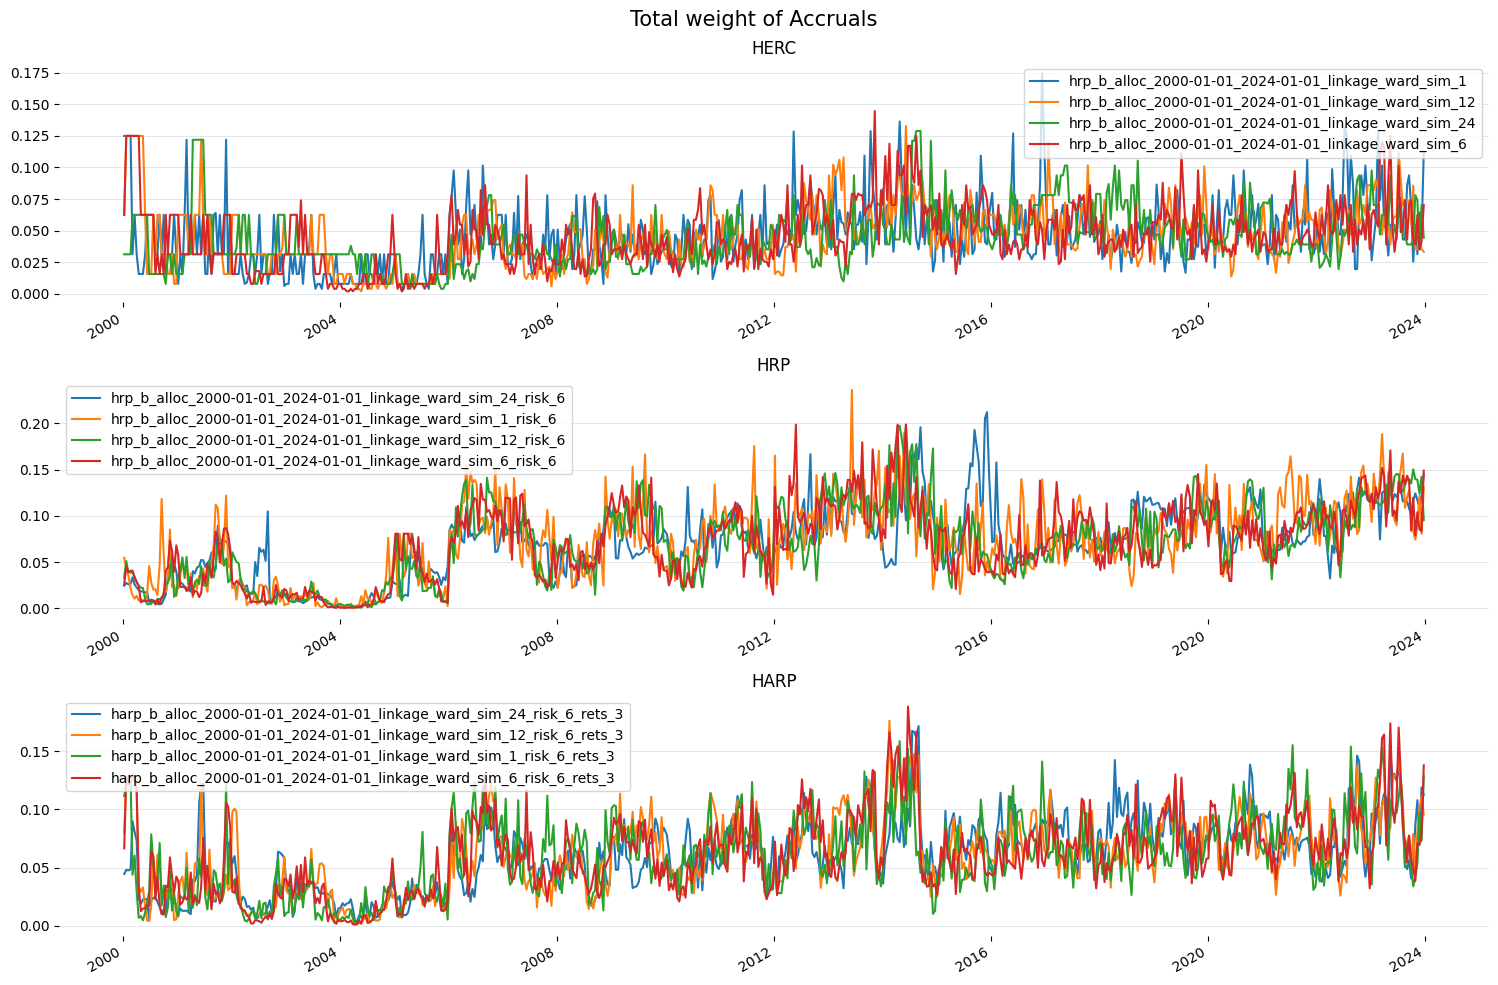

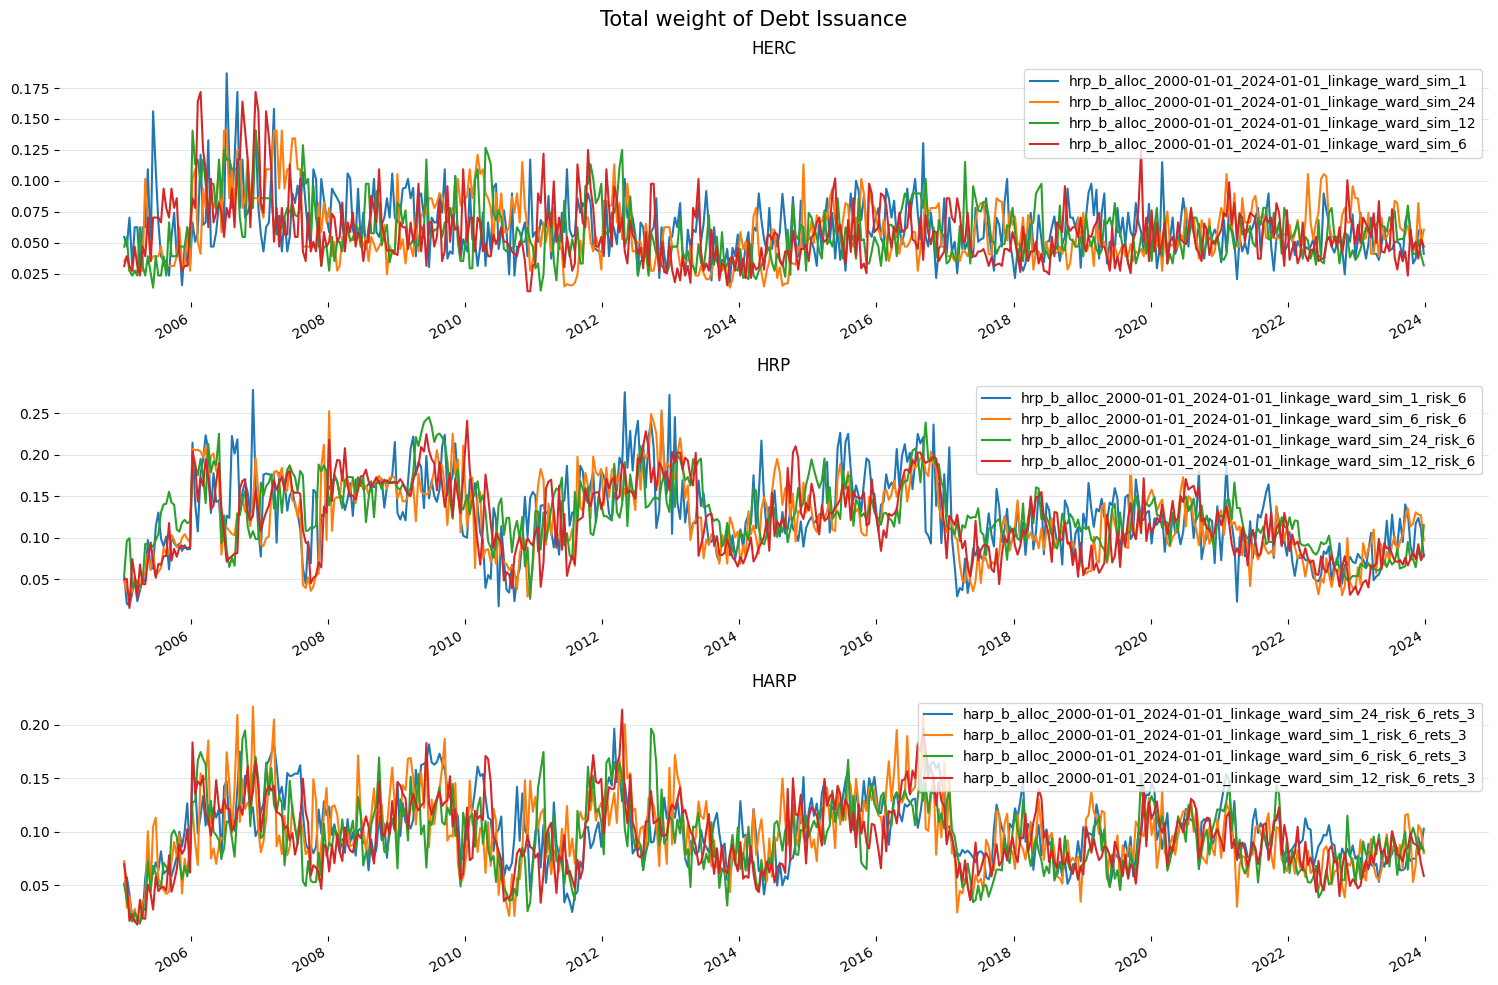

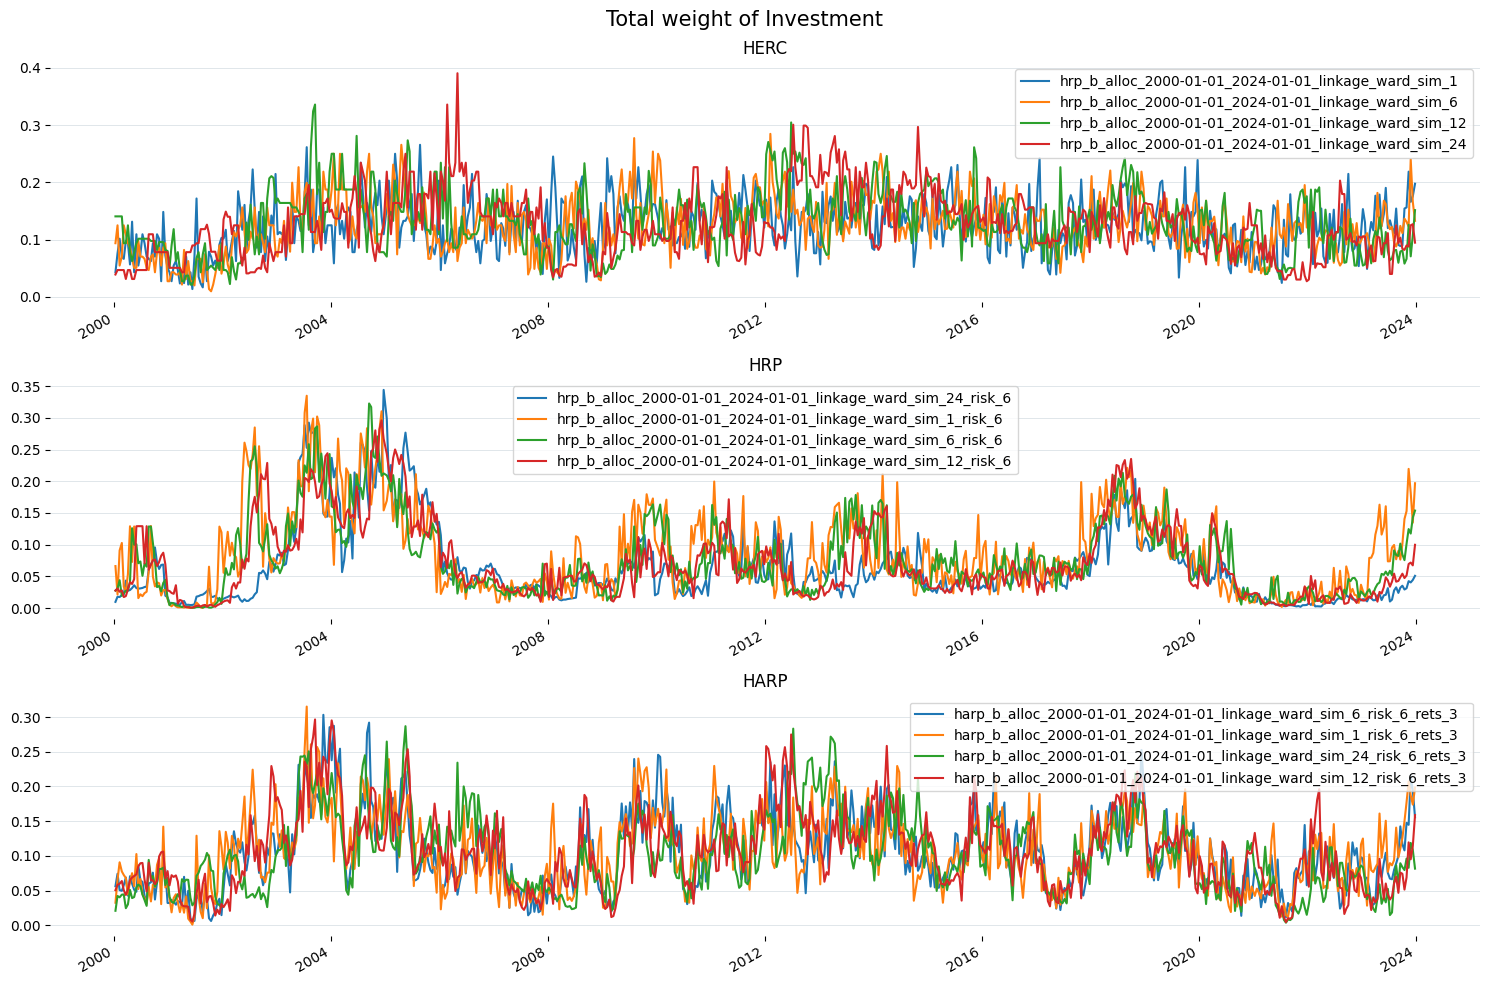

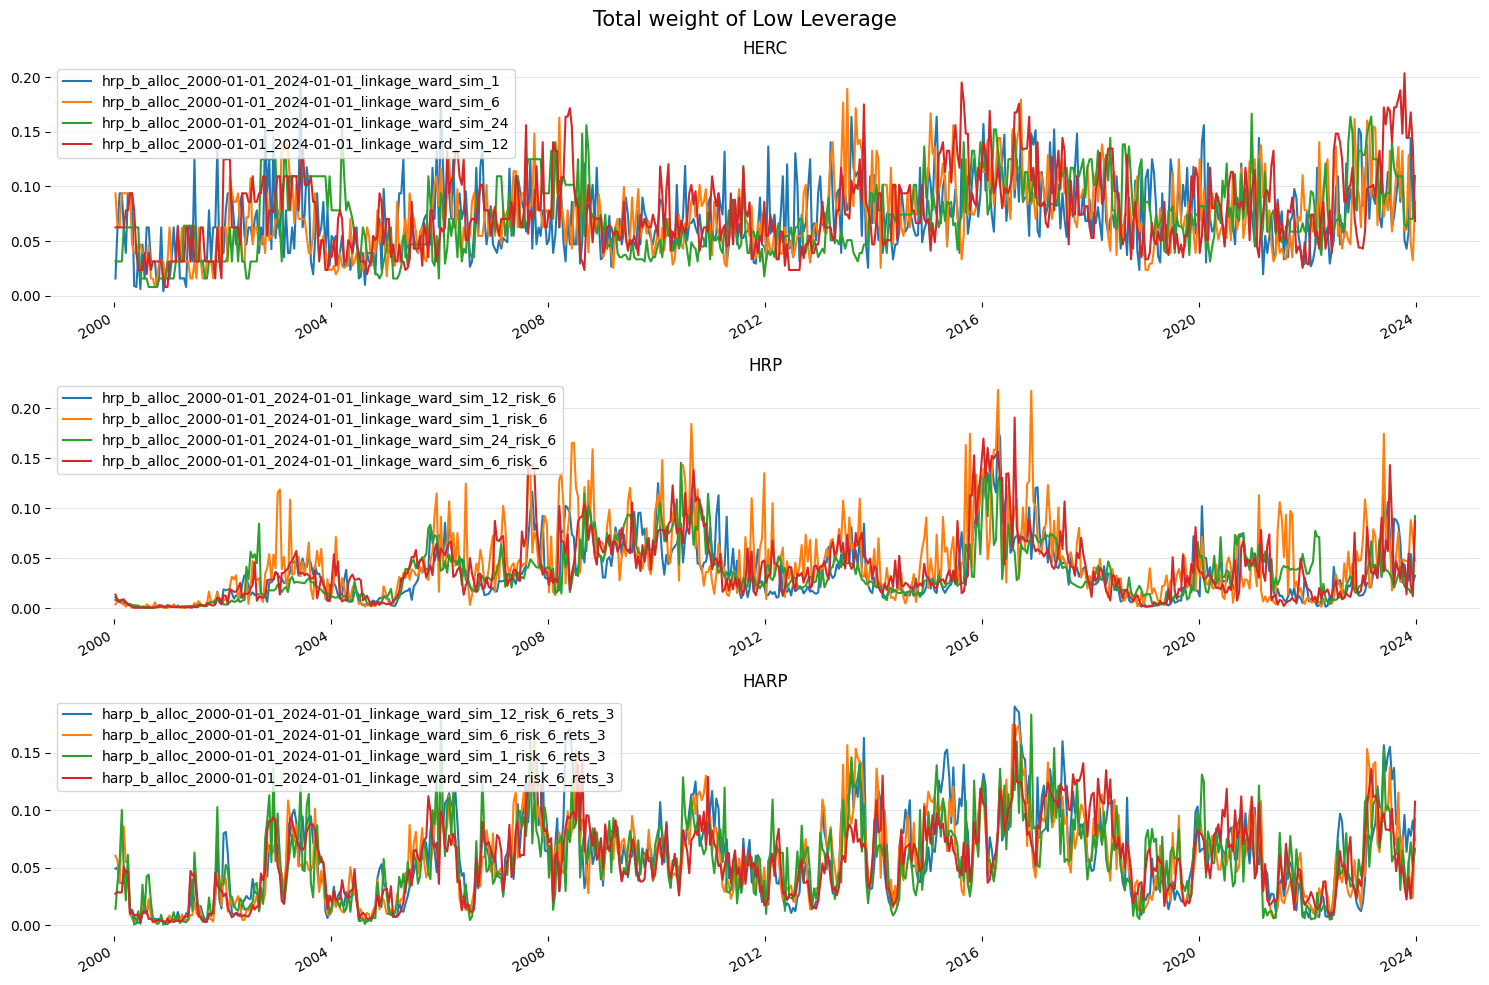

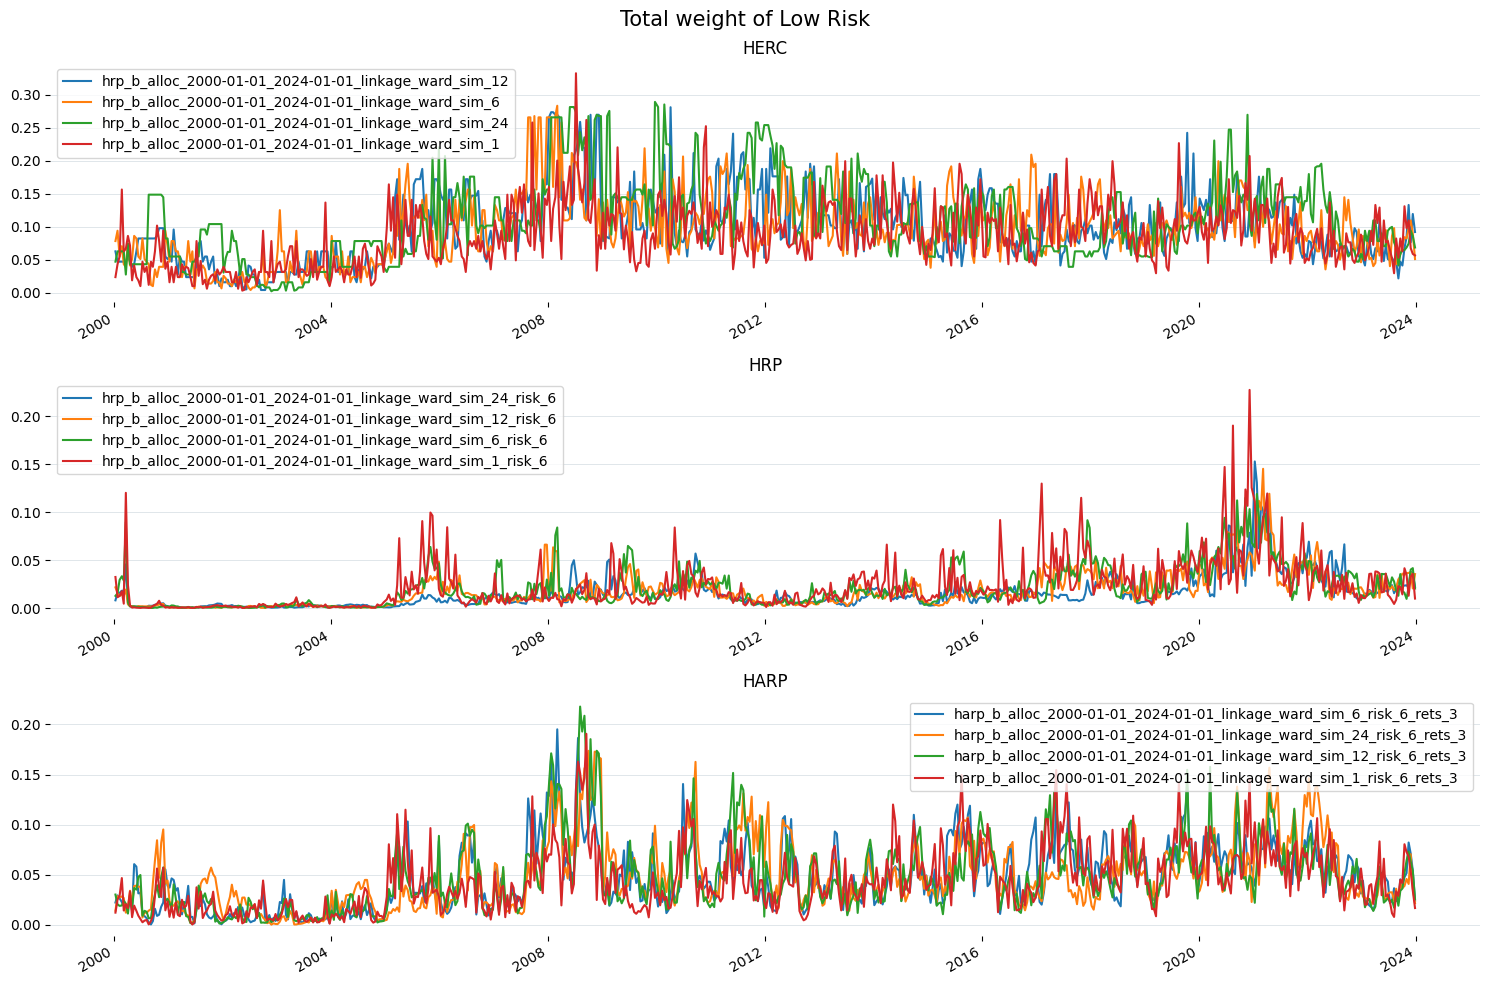

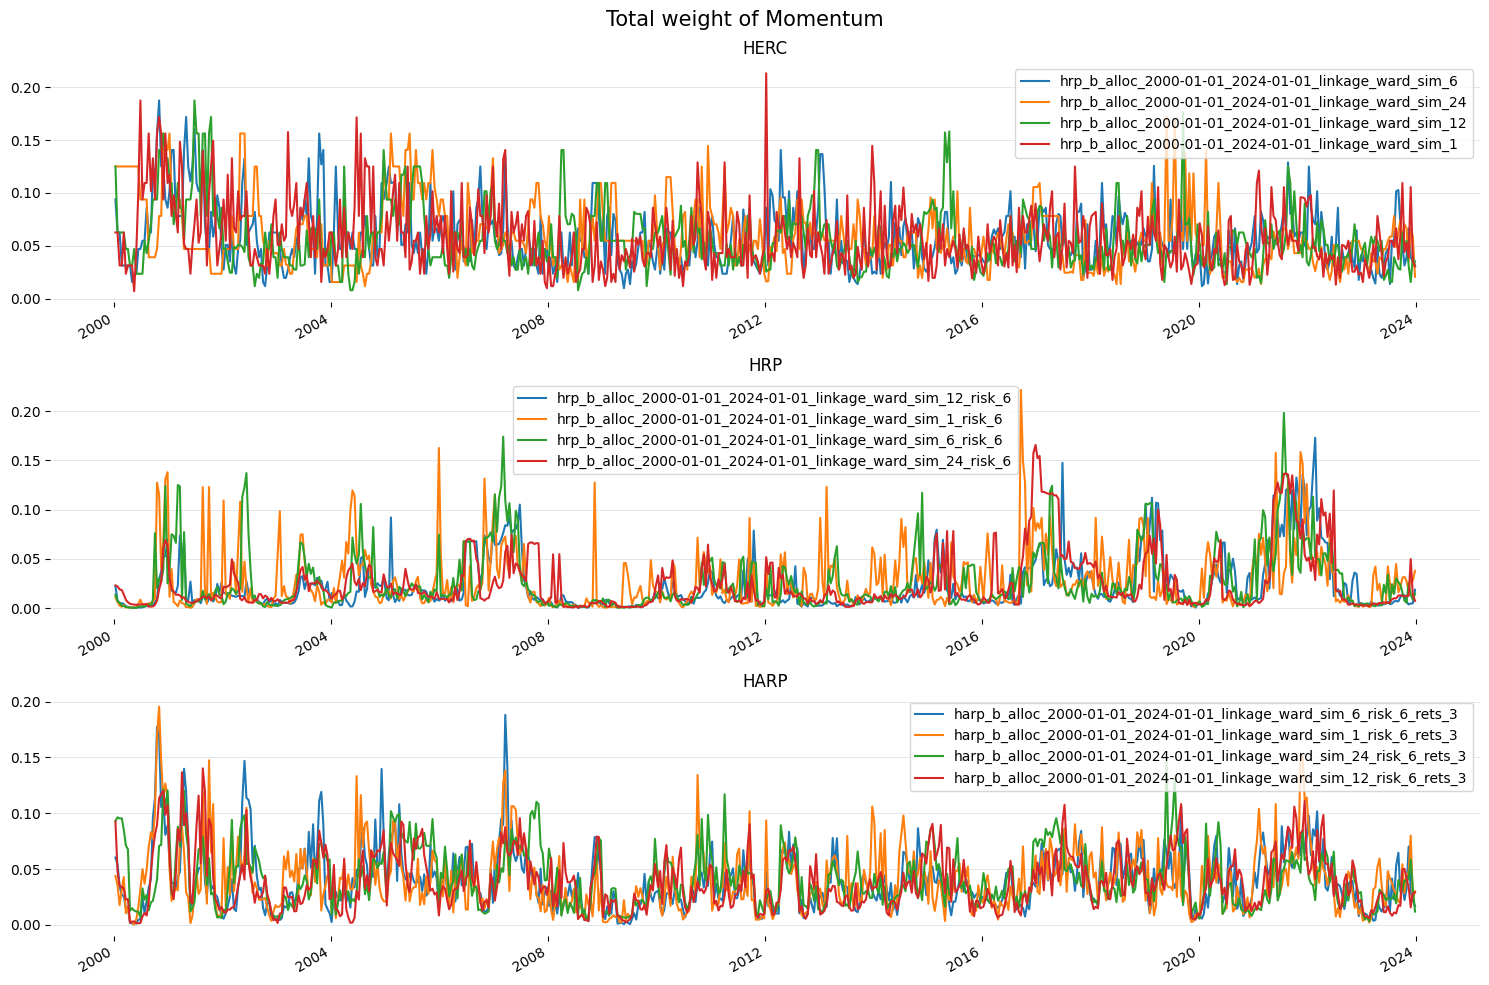

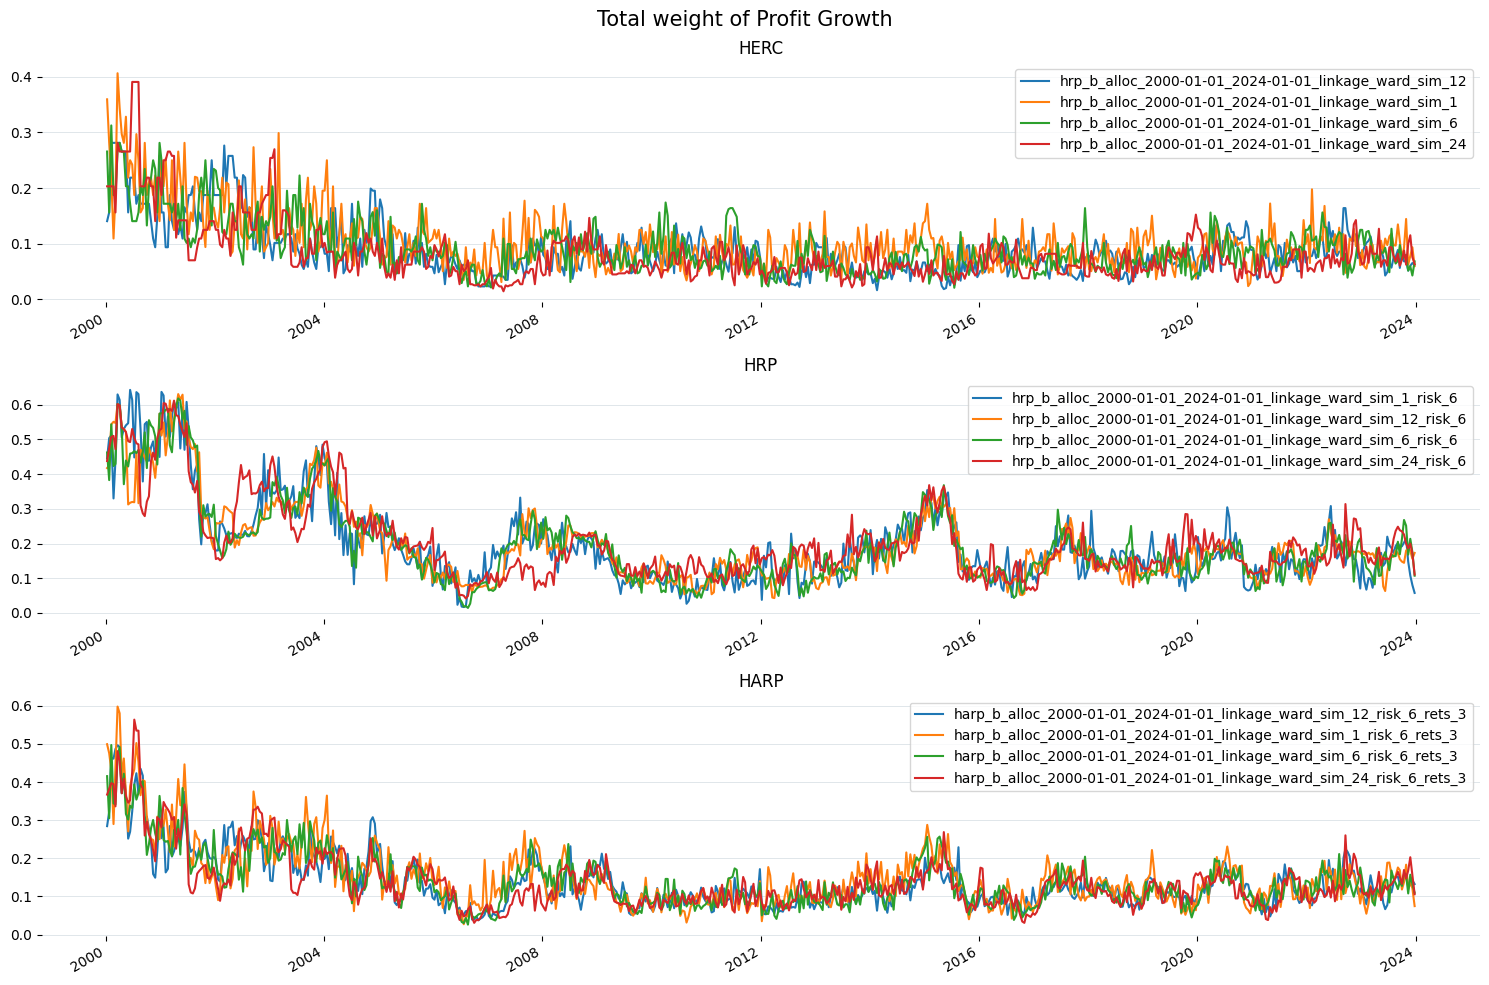

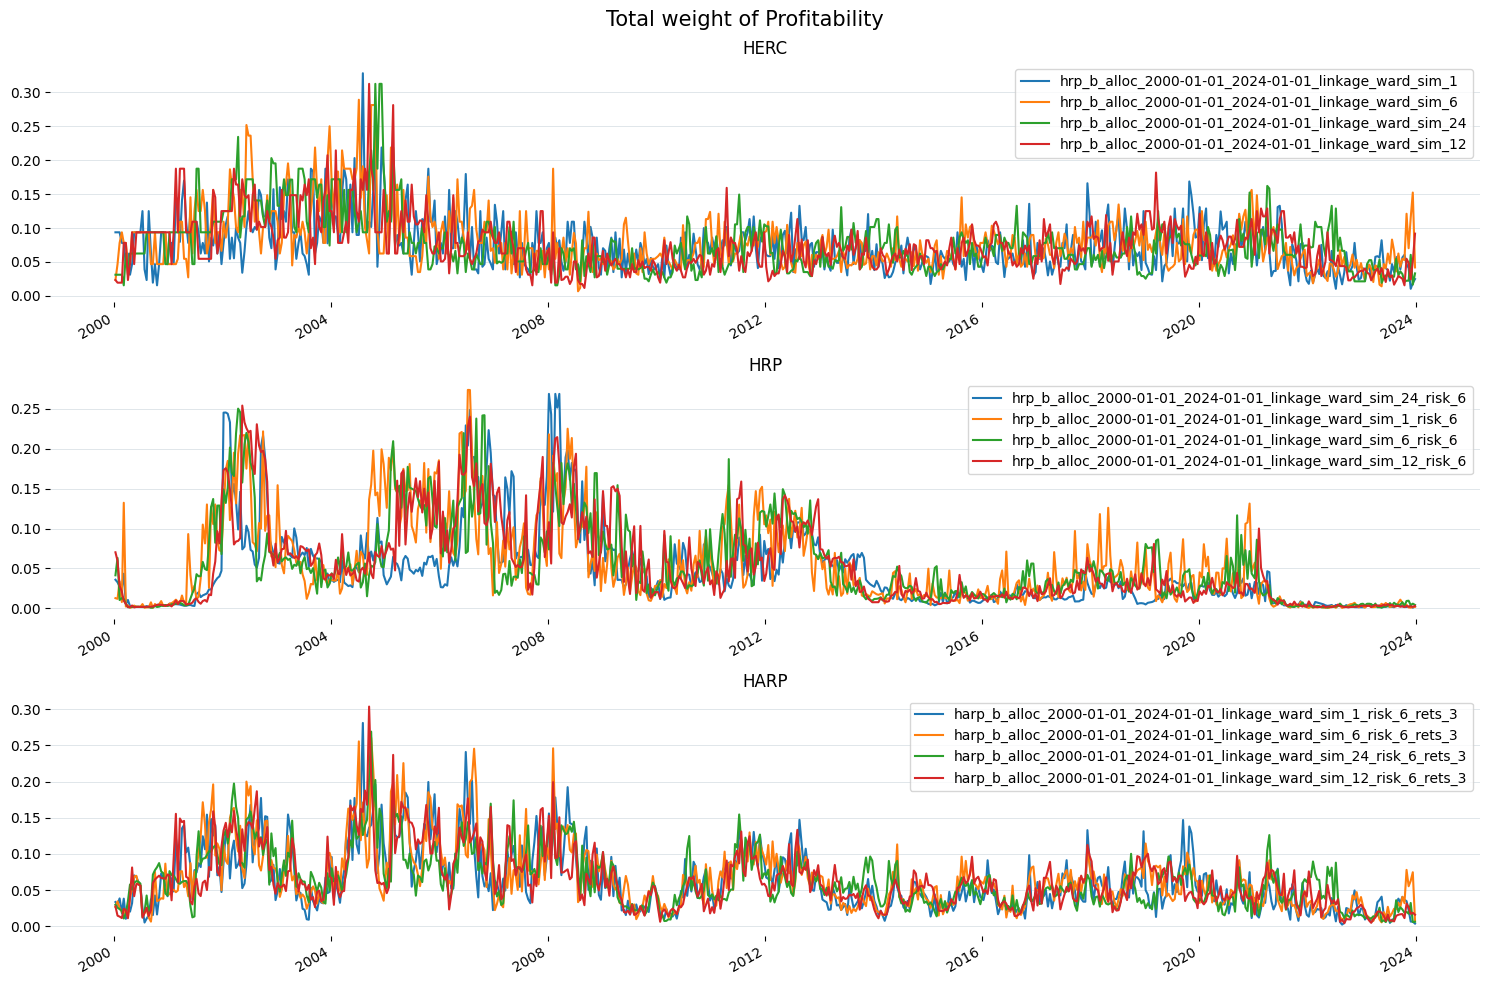

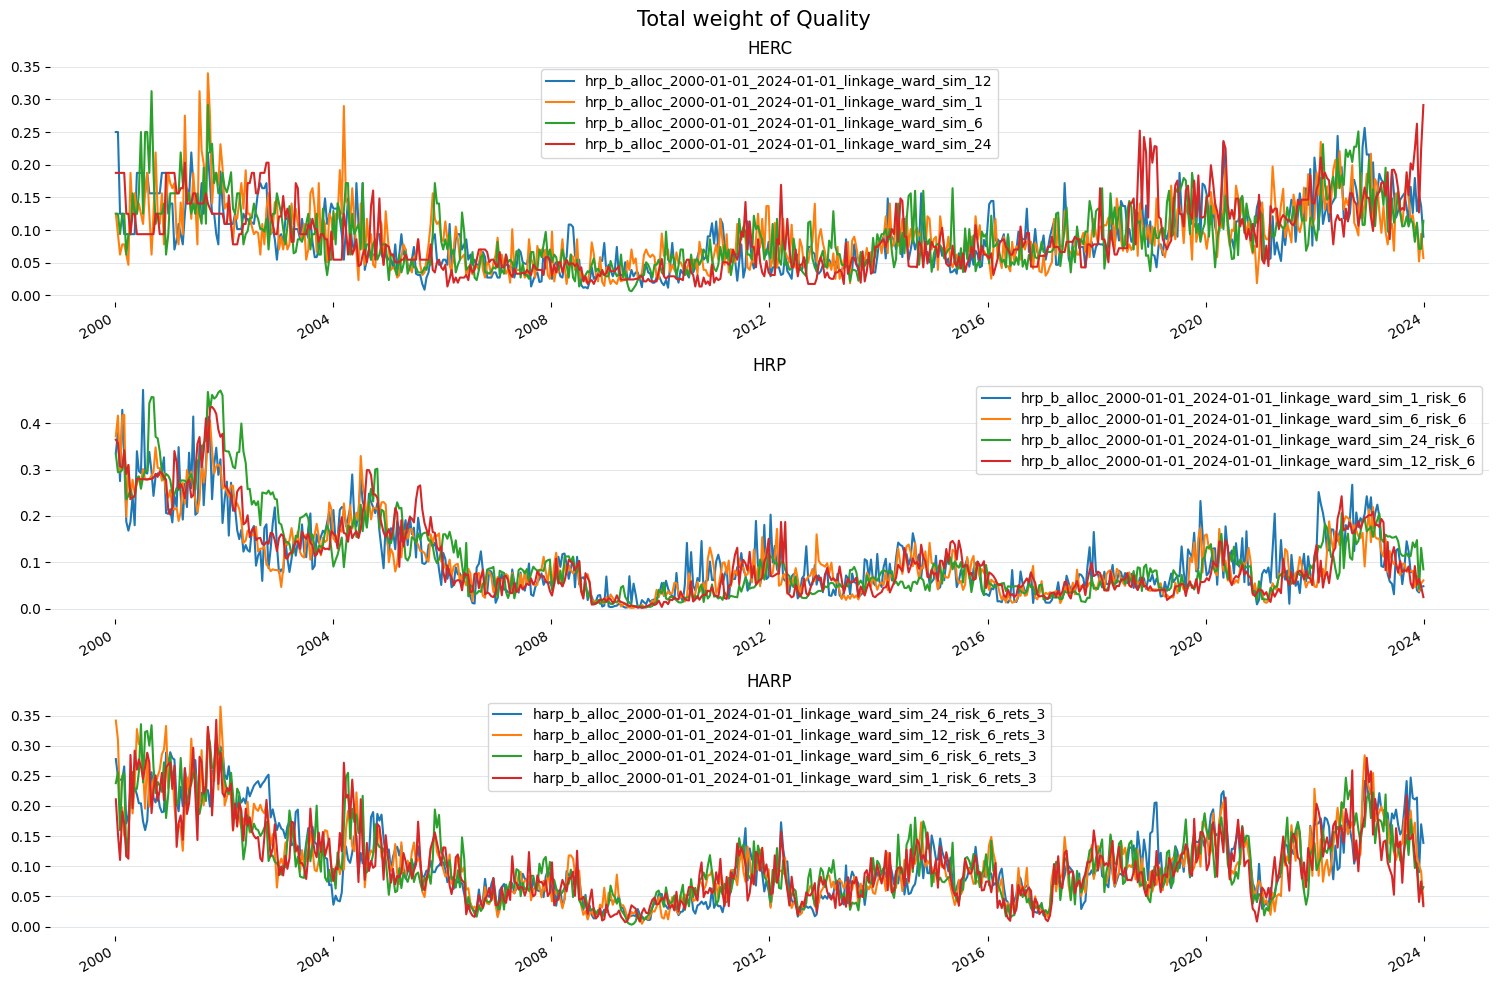

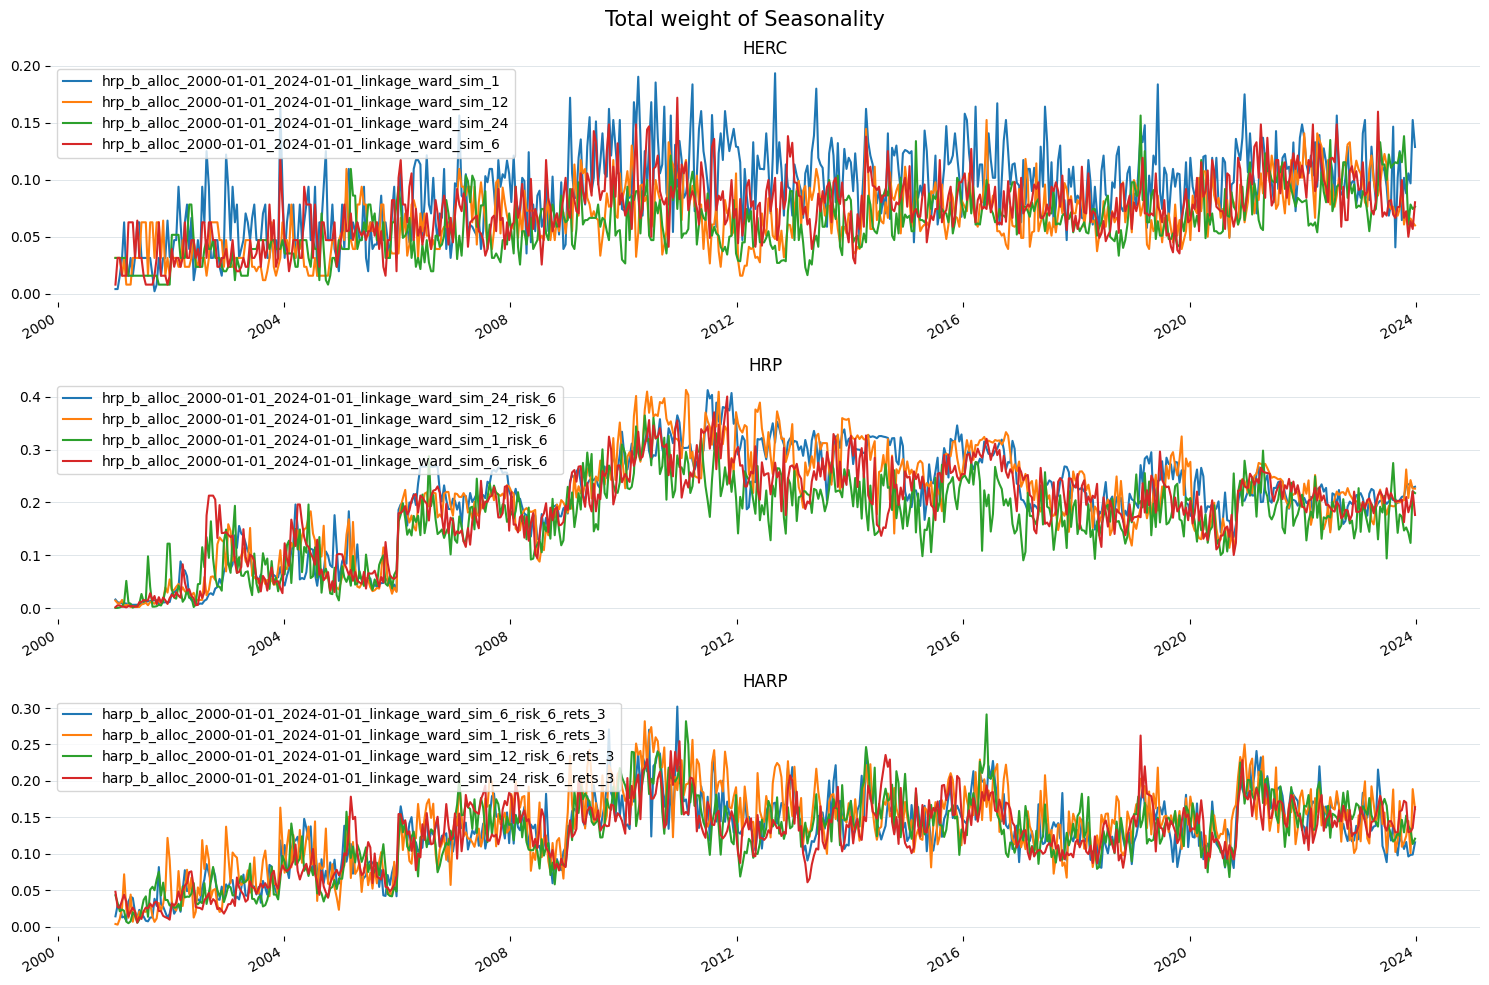

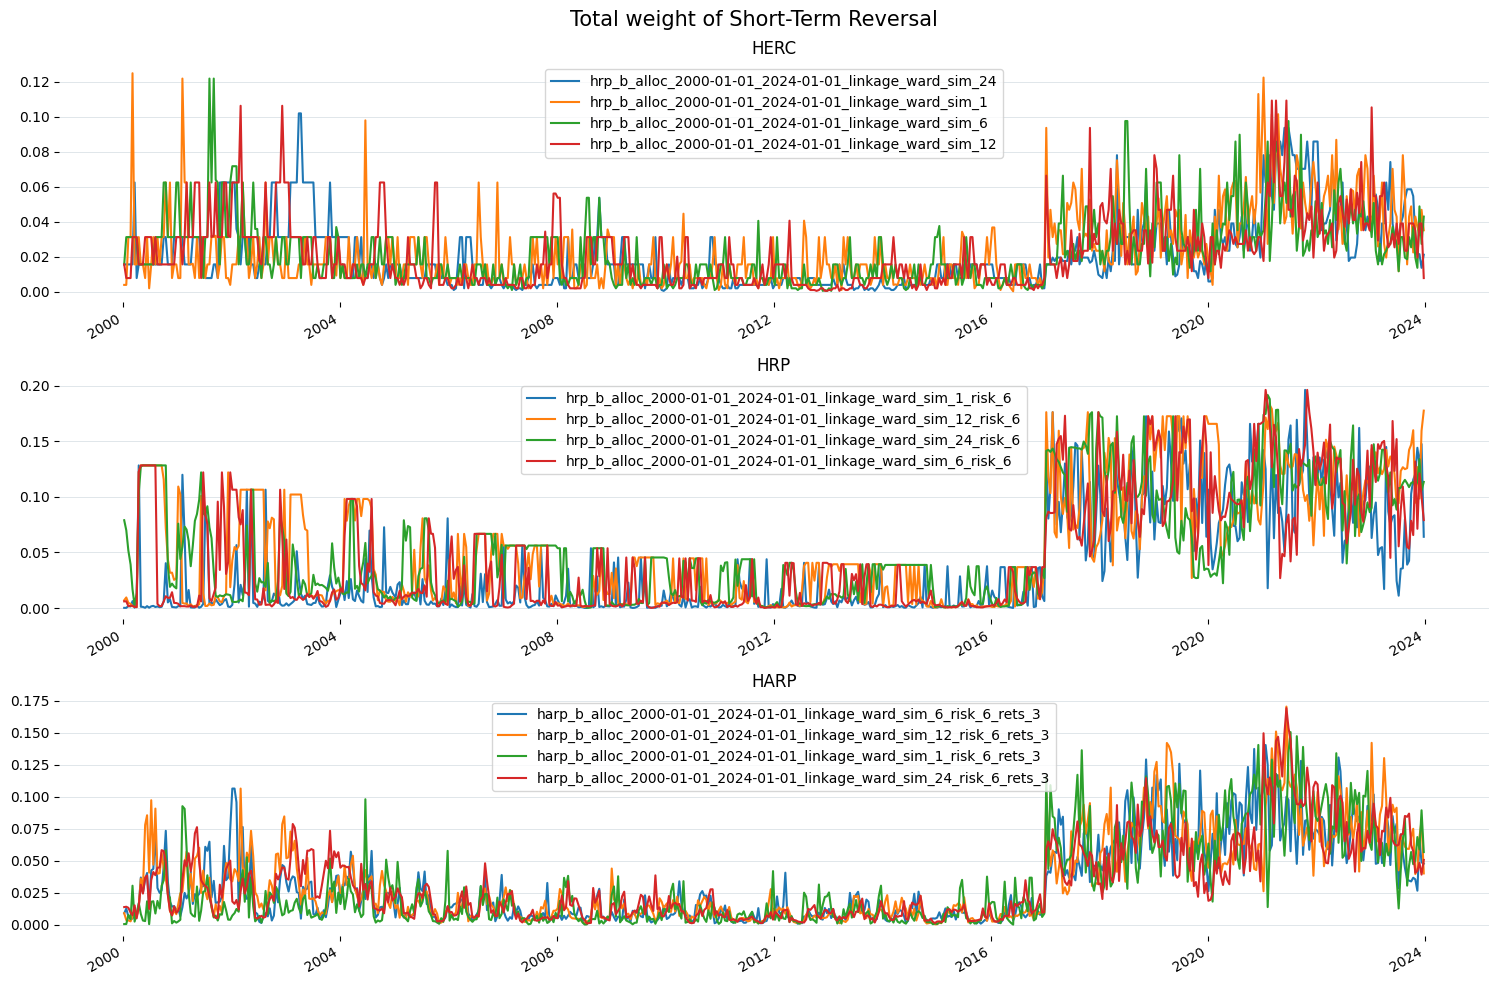

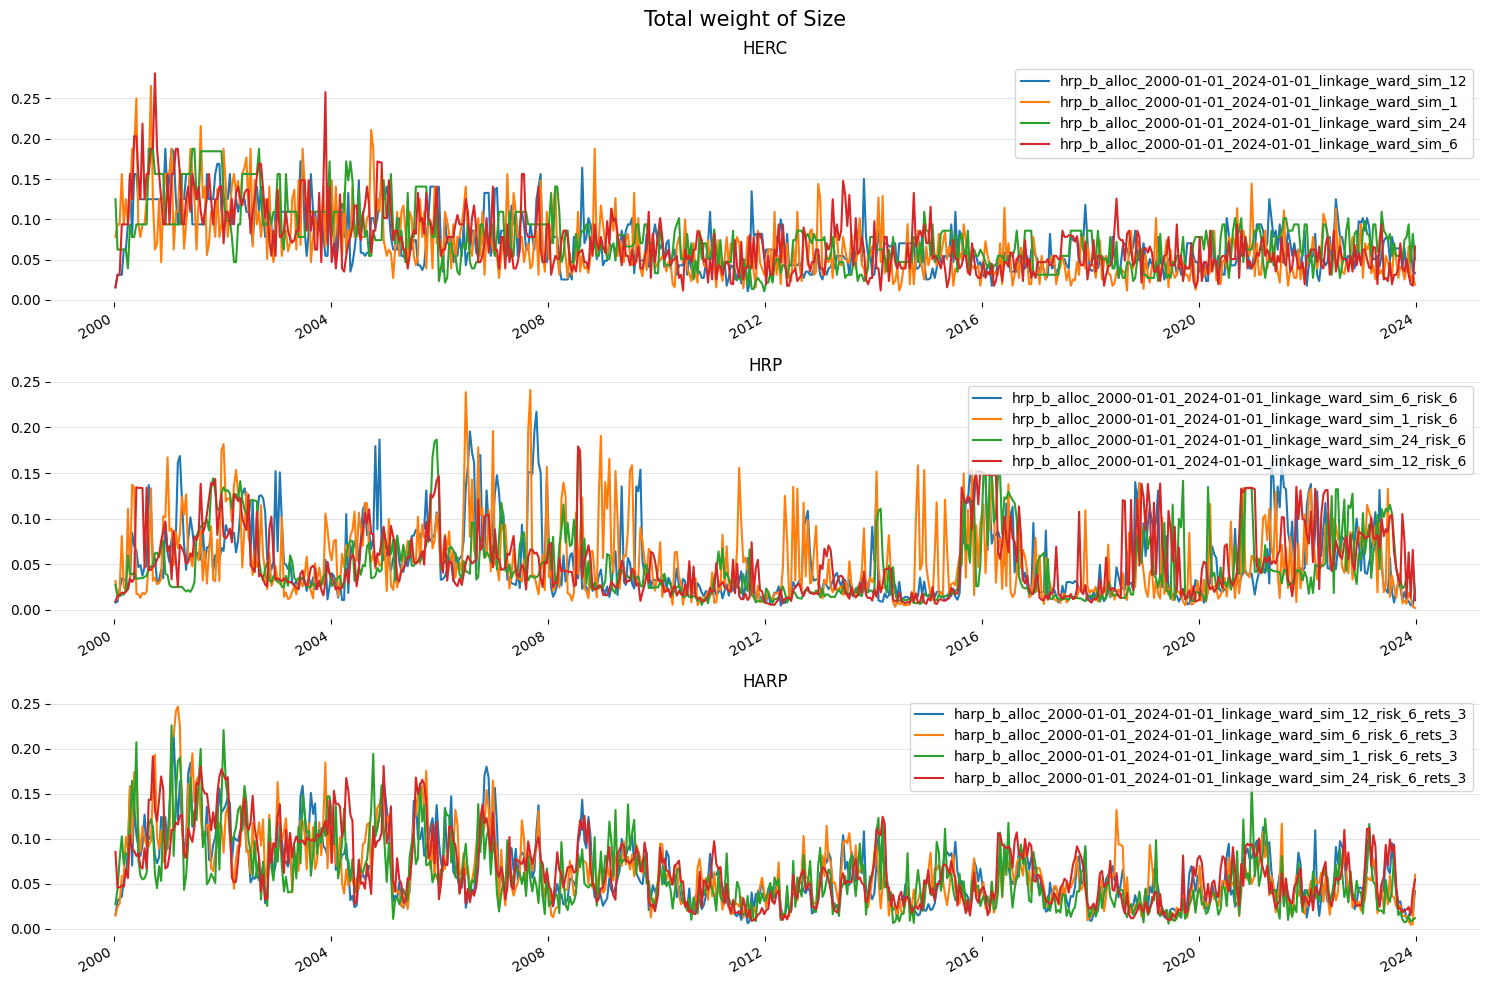

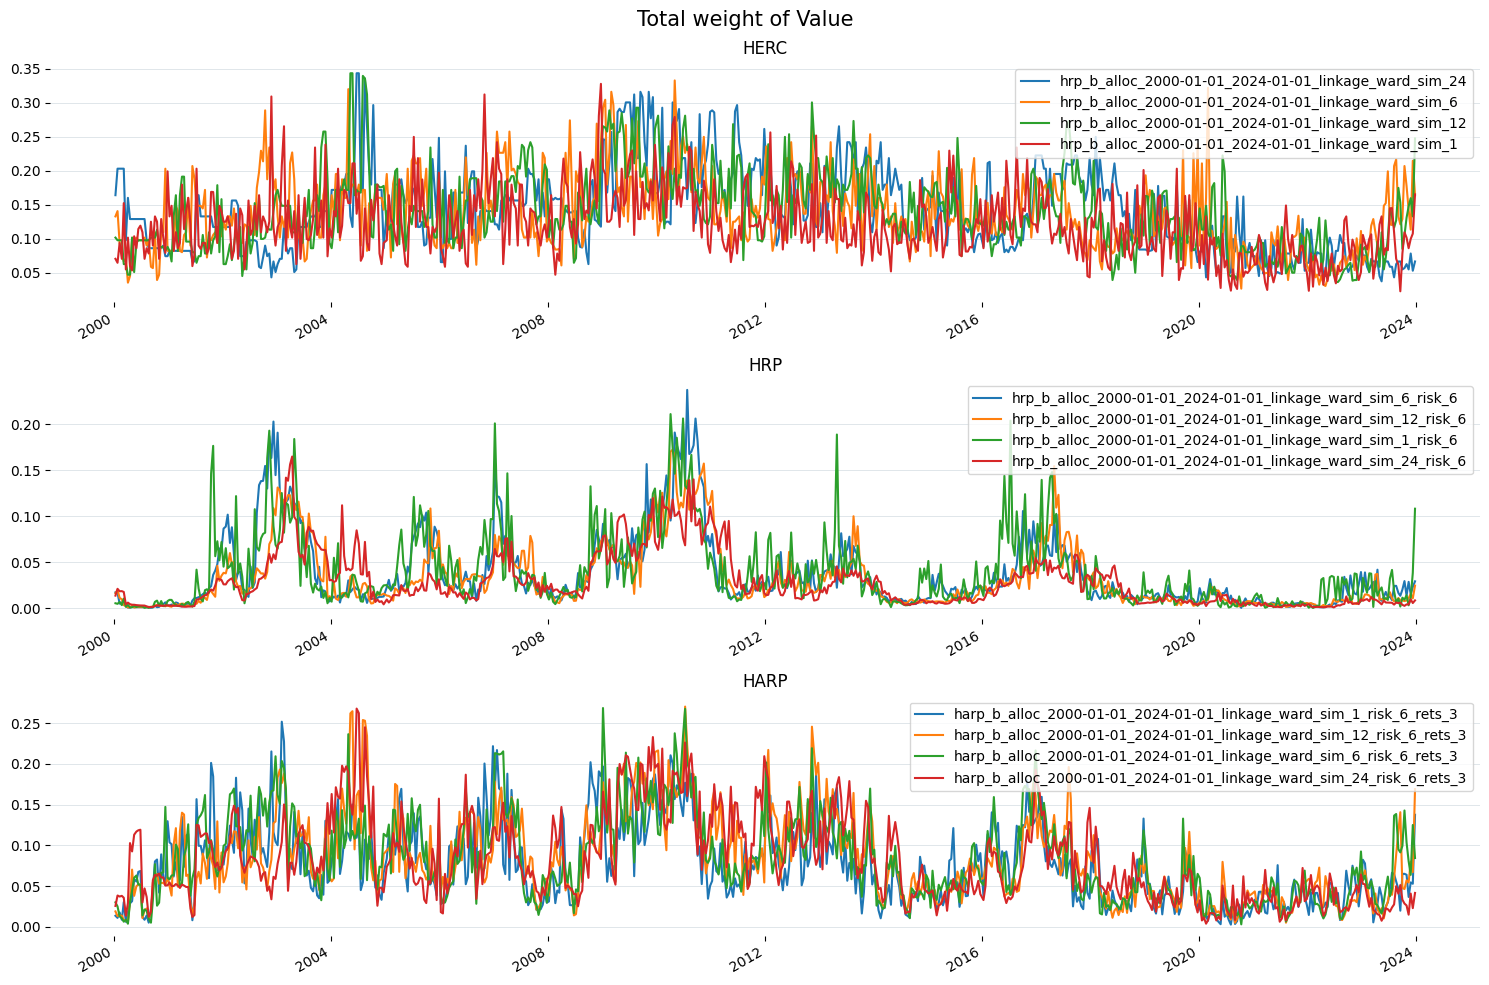

In [8]:
FACTORS = df_alloc.select("cluster").to_series().unique().sort()

for factor in FACTORS:
    plot_weights_per_time_per_factor(
        df_weights=df_alloc.group_by(["alloc_model", "date", "cluster"])
        .agg(pl.col("relative_weight").sum())
        .sort("date"),
        factor=factor,
        sim_windows=SIM_WINDOWS,
        alloc_methods_filter_expr=ALLOC_METHOD_FILTER_EXPR,
        title=f"Total weight of {factor}",
    )

As observed, weights are fairly evenly distributed across all models, preventing any single factor from dominating. Except for brief periods, no factor consistently receives the majority of weight. To mitigate potential concentration, we can implement a filter to limit the maximum weight allocated to a global factor. (*) However, this filter may not significantly alter the overall results.


(*) In this simple example, we didn't apply this filter.